<a href="https://colab.research.google.com/github/nyp-sit/it3103/blob/main/week15/human_activity_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Human Activity Recognition using 2D-Pose

In this practical, we will be developing a model to recognise activity such as jumping, boxing, waving 1 hand, etc. The activity is defined as a sequence of human poses (given by keypoints of skeletal joints) and these poses are estimated by a pretrained model (Google's PoseNet).


## Section 1 - Import Libraries and Setup Folders

Let's import all the necessary libraries

In [1]:
import pandas as pd
import os
import numpy as np
import math
from tqdm import tqdm
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import rc

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Input, Bidirectional, Dropout, LSTM, TimeDistributed, Flatten


## Section 2 - Dataset

We will be using the following dataset from 
https://github.com/stuarteiffert/RNN-for-Human-Activity-Recognition-using-2D-Pose-Input

The data is 2D positions (x,y coordinates) of 18 joints across a timeseries of 32 frames (window-width), with an associated class label for the frame series.

The dataset consist of the following files:
- X_test.txt : testing dataset x inputs (36 keypoints per line, 32 lines per datapoint)
- X_train.txt : training dataset x inputs (36 keypoints per line, 32 lines per datapoint)
- X_val.txt : validation dataset x inputs (36 keypoints per line, 32 lines per datapoint)
- Y_test.txt : testing class labels
- Y_train.txt : training class labels
- Y_val.txt : validation class labels

In [2]:
!wget https://nyp-aicourse.s3.ap-southeast-1.amazonaws.com/it3103/2D-Pose-Data.zip
!unzip 2D-Pose-Data.zip

--2021-07-18 15:48:11--  https://nyp-aicourse.s3.ap-southeast-1.amazonaws.com/it3103/2D-Pose-Data.zip
Resolving nyp-aicourse.s3.ap-southeast-1.amazonaws.com (nyp-aicourse.s3.ap-southeast-1.amazonaws.com)... 52.219.36.167
Connecting to nyp-aicourse.s3.ap-southeast-1.amazonaws.com (nyp-aicourse.s3.ap-southeast-1.amazonaws.com)|52.219.36.167|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19774999 (19M) [application/zip]
Saving to: ‘2D-Pose-Data.zip.1’

2D-Pose-Data.zip.1  100%[===================>]  18.86M  6.39MB/s    in 3.0s    

2021-07-18 15:48:15 (6.39 MB/s) - ‘2D-Pose-Data.zip.1’ saved [19774999/19774999]

Archive:  2D-Pose-Data.zip
replace 2D-Pose-Data/README.md? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: 2D-Pose-Data/README.md  
replace 2D-Pose-Data/X_test.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: 2D-Pose-Data/X_test.txt  
  inflating: 2D-Pose-Data/X_train.txt  
  inflating: 2D-Pose-Data/X_val.txt  
  inflating: 2D-Pose-Data/X_v

In [40]:
train_df = pd.read_csv('2D-Pose-Data/X_train.txt', header=None)
train_label_df = pd.read_csv('2D-Pose-Data/Y_train.txt', header=None)
test_df = pd.read_csv('2D-Pose-Data/X_test.txt', header=None)
test_label_df = pd.read_csv('2D-Pose-Data/Y_test.txt', header=None)

In [46]:
train_df.shape

(724000, 36)

In [47]:
def fun(x): 
    print(x)

In [ ]:
train_df[:5].apply(fun, axis=1)

In [4]:
train_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35
0,295.914,161.579,307.693,203.413,281.546,203.368,274.997,251.562,267.194,293.253,337.619,204.669,347.958,255.443,341.541,295.866,286.810,289.393,297.196,355.832,297.220,405.371,321.967,291.959,327.143,358.408,328.528,411.922,294.546,156.420,305.002,156.418,0.0,0.0,318.083,161.632
1,295.855,161.600,307.684,203.408,281.529,203.385,274.989,251.574,267.191,291.961,337.615,204.646,347.974,254.209,344.093,295.816,286.803,289.377,297.165,355.827,297.205,404.095,323.248,290.652,324.564,358.409,328.493,410.630,293.252,157.686,303.706,157.706,0.0,0.0,318.024,161.654
2,293.296,161.620,307.655,203.410,280.228,203.382,274.986,251.591,267.262,289.373,337.590,204.656,348.003,255.468,341.536,295.919,286.826,291.959,295.882,357.139,297.209,402.798,324.527,290.690,321.931,359.707,328.522,411.946,289.374,157.686,299.798,157.714,0.0,0.0,316.776,161.679
3,291.978,161.658,307.619,204.678,278.918,204.659,275.001,254.114,269.794,289.363,337.571,205.963,348.004,255.514,342.818,295.928,288.041,291.984,294.585,358.396,297.243,402.814,324.536,293.275,319.335,359.713,328.479,411.947,288.101,157.727,298.487,158.985,0.0,0.0,316.720,161.697
4,288.063,168.120,306.362,209.835,276.384,211.108,275.010,255.461,275.003,294.581,336.288,209.847,348.017,258.065,340.210,302.403,288.111,294.598,293.282,359.758,297.246,405.358,325.820,294.576,318.062,362.343,329.774,411.884,286.774,161.596,297.133,161.601,0.0,0.0,315.402,166.840


In [7]:
train_label_df.head()

,0
0,1
1,1
2,1
3,1
4,1


In [8]:
train_label_df.value_counts()

5    5055
4    4760
3    4724
2    3545
1    2400
6    2141
dtype: int64

## Section 3- Create the input data

We cannot use the dataframe directly for use by our LSTM network. We need to create a dataset that consists sequence of 32 timesteps (frames) of 36 keypoints. In other words, we need our data to be of the shape (batch_size, 32, 36).

In [15]:
X_train = train_df.to_numpy().reshape(-1, 32, 36)
y_train = train_label_df.to_numpy() - 1
print(X_train.shape)
print(y_train.shape)

(22625, 32, 36)
(22625, 1)


In [16]:
X_test = test_df.to_numpy().reshape(-1, 32, 36)
y_test = test_label_df.to_numpy() - 1
print(X_test.shape)
print(y_test.shape)

(5751, 32, 36)
(5751, 1)


In [17]:
# Process OpenPose's Joints
#
def process_joints(x):

    # No processing yet.
    return x

## Section 5 - Visualize Our Dataset



We can view each frame as a timestep on the x-axis, and each of the 36 numbers (the x and y coordinates of 18 joints) as individual line plots.  It provides some visual clue as to how the different joints move over time, but they are still difficult to imagine and visualize.

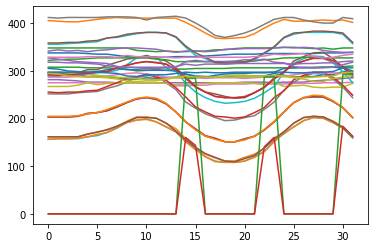

In [18]:
%matplotlib inline 
sample = 0
plt.plot(X_train[sample])
plt.show()

A better way to visualize is do a scatter plot of the X and Y coordianates of the various joints and animating them so that we can see their movements over time.

NOTE: These are the various types of actions captured in the dataset:
JUMPING, JUMPING_JACKS, BOXING, WAVING_2HANDS, WAVING_1HAND", "CLAPPING_HANDS"

In [19]:
sample = 0

# This function returns a set of data for every frame that is
# called from the animation.FuncAnimation below.
#
def animate_pose(frame):
    # Retrieve the even number values as X-coordinates
    # and the odd number values as Y-coordinates
    #
    # Once you have these 2 sets of values, you can
    # pass them into the line.set_data to get matplotlib
    # to draw a scatter plot 
    #
    graph_x = X_train[sample][frame][0::2]
    graph_y = X_train[sample][frame][1::2]
    line.set_data(graph_x, graph_y)
    return line,

fig, ax = plt.subplots()
plt.close()

ax.set_xlim(0, 800)
ax.set_ylim(600, 0)

line, = ax.plot([], [], 'o', color='black');

anim = animation.FuncAnimation(fig, animate_pose, 32,  interval=50, blit=True)
rc('animation', html='jshtml')
anim

## Section 6 - Define and Train Your Model

Try to define your Keras sequential model using any Keras layers. You should have minimally:

1. At least 1 RNN, or GRU, or LSTM Layer
2. At least 1 Dense Layer (for the softmax classification)
3. The input shape should be (32, 36)

Try to experiment and find a suitable model. You can decide if you want to use Bidirectional models, and add any Dropout layers if it helps to improve your model performance. Share your model with the class together with the validation accuracy!

A typical model can be designed this way:

```
    model.add(LSTM(128, input_shape=(32, 36)))
    model.add(Dropout(0.2))

    model.add(Dense(6, activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
```

This is part of model selection and evaluation in any machine learning project. 

You may find that a good validation accuracy for you model may hover near about 85-90%. 

In [20]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5])

In [24]:
# Create our LSTM model here
#
def create_model():

    # Use Keras to create a Sequential model here with any layers that 
    # you'd like.
    #
    model = Sequential()

    model.add(LSTM(128, input_shape=(32, 36)))
    model.add(Dropout(0.2))

    model.add(Dense(6, activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model


# Create our model
#
model = create_model()


# Create the training folder
#
training_session_id = datetime.now().strftime("%Y-%m-%d %H-%M-%S")
training_session_folder = '/train_%s' % (training_session_id)
os.makedirs(training_session_folder, exist_ok=True)

callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath=training_session_folder + '/model.{epoch:04d}-val_acc-{val_accuracy:4.2f}-loss-{val_loss:4.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]


# Train our model
#
history = model.fit(x=X_train, y=y_train, batch_size=256, epochs=40, verbose=1, callbacks=callbacks_list, validation_data=(X_test, y_test))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 128)               84480     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 774       
Total params: 85,254
Trainable params: 85,254
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
89/89 [==============================] - 4s 21ms/step - loss: 1.6124 - accuracy: 0.3537 - val_loss: 1.4564 - val_accuracy: 0.4655
Epoch 2/40
89/89 [==============================] - 1s 14ms/step - loss: 1.4772 - accuracy: 0.4223 - val_loss: 1.3355 - val_accuracy: 0.5300
Epoch 3/40
89/89 [==============================] - 1s 14ms/step - loss: 1.3285 - accuracy: 0.4943

In [32]:
X_train.shape

(22625, 32, 36)

In [23]:
model.evaluate(X_test, y_test)

180/180 [==============================] - 1s 5ms/step - loss: 0.3688 - accuracy: 0.8612


[0.36878636479377747, 0.8612415194511414]

## Section 7 - Scale / Translation Normalization

So far, we have not talked about how we can normalize our skeletal keypoints so that the pose data is scale / translation invariant. This means that regardless of how far the person is from the camera, or when the person moves left or right or up or down, the coordinates of all joint positions should always be relative to a fixed frame of reference.

To take care of translation (left / right / up / down) invariance, we are shift all points together so that neck point is always placed at (0, 0). 

To take care of scale invariance, we estimate the torso height (which is either the length of the neck point to either hip, or the width of the shoulders). We then divide all joint coordinates by the torso height.

To do so, we will create a `process_joints()` function to include code to normalize the skeleton key points as described above:

1. ref = P[1] or the midpoint of P[2], P[5]
2. reflength = length(ref to P[8]) or length(ref to P[11]) 
3. Compute 
   - P[i].x = (P[i].x - ref.x) / reflength
   - P[i].y = (P[i].y - ref.y) / reflength

```

# Declare a function that can compute length between two points
#   (x1,y1) - (x2,y2)
#
def compute_length(x1, y1, x2, y2):
    return math.sqrt((x1-x2)*(x1-x2) + (y1-y2)*(y1-y2))

# Process OpenPose's Joints
# NOTE: The "x" parameter consists of an array of consecutive x and y values 
# within the same array.
#
# x = [p0.x, p0.y, p1.x, p1.y, p2.x, p2.y, ..., p17.x, p17.y]
#     (a total of 36 values)
# 
def process_joints(x):

    r = [0] * 36

    # Initialize some values for the reference length and the reference point.
    #
    refx = 0
    refy = 0
    reflength = 1

    # Step 1: Let's find the reference point (neck)
    #
    if x[2] != 0 or x[3] != 0:         
        refx = x[2]                # use the neck X, Y
        refy = x[3]
    elif (x[4] != 0 or x[5] != 0) and (x[10] != 0 or x[11] != 0):
        refx = (x[4] + x[10]) / 2  # estimate the neck X, Y from the mid point
        refy = (x[5] + x[11]) / 2  # of the left/right shoulder
    
    # Step 2: Let's first estimate the torso length.
    #
    if x[16] != 0 and x[17] != 0:             
        reflength = compute_length(x[16], x[17], refx, refy)   # neck to right hip
    elif x[22] != 0 and x[23] != 0:
        reflength = compute_length(x[22], x[23], refx, refy)   # neck to left hip

    # Step 3:
    # Perform the translation and the scaling.
    #
    for i in range(0, 18):
        r[i*2] = (x[i*2] - refx) / reflength
        r[i*2 + 1] = (x[i*2 + 1] - refy) / reflength
    
    # Return the re-mapped and normalized result
    #
    return r
```

In [60]:
# Declare a function that can compute length (euclidean distance) between two points
#   (x1,y1) - (x2,y2)
def compute_length(x1, y1, x2, y2):
    return math.sqrt((x1-x2)*(x1-x2) + (y1-y2)*(y1-y2))

# Process OpenPose's Joints

# NOTE: The "keypoints" parameter consists of an array of consecutive x and y values 
# within the same array.
#
# keypoints = [p0.x, p0.y, p1.x, p1.y, p2.x, p2.y, ..., p17.x, p17.y]
#     (a total of 36 values) 
def process_joints(keypoints):

    normalized_keypoints = [0] * 36

    refx = 0
    refy = 0
    reflength = 1

    # Step 1: Let's find the reference point (neck)
    #
    if keypoints[2] != 0 or keypoints[3] != 0:         
        refx = keypoints[2]                # use the neck X, Y
        refy = keypoints[3]
    elif (keypoints[4] != 0 or keypoints[5] != 0) and (keypoints[10] != 0 or keypoints[11] != 0):
        refx = (keypoints[4] + keypoints[10]) / 2  # estimate the neck X, Y from the mid point
        refy = (keypoints[5] + keypoints[11]) / 2  # of the left/right shoulder
    
    # Step 2: Let's first estimate the torso length.
    #
    if keypoints[16] != 0 and keypoints[17] != 0:             
        reflength = compute_length(keypoints[16], keypoints[17], refx, refy)   # neck to right hip
    elif keypoints[22] != 0 and keypoints[23] != 0:
        reflength = compute_length(keypoints[22], keypoints[23], refx, refy)   # neck to left hip

    # Step 3:
    # Perform the translation and the scaling.
    #
    for i in range(0, 18):
        normalized_keypoints[i*2] = (keypoints[i*2] - refx) / reflength
        normalized_keypoints[i*2 + 1] = (keypoints[i*2 + 1] - refy) / reflength
    
    # Return the re-mapped and normalized result
    #
    return normalized_keypoints



In [61]:
train_df_normalized = train_df.apply(process_joints, axis=1, result_type='expand')
test_df_normalized = test_df.apply(process_joints, axis=1, result_type='expand')

In [58]:
train_df_normalized.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35
0,-0.133127,-0.472809,0.0,0.0,-0.295514,-0.000509,-0.369531,0.544181,-0.457721,1.015374,0.338224,0.014195,0.455076,0.588044,0.382551,1.044906,-0.236020,0.971748,-0.118637,1.722643,-0.118366,2.282534,0.161325,1.000749,0.219824,1.751757,0.235478,2.356574,-0.148588,-0.531116,-0.030414,-0.531139,-3.477554,-2.298979,0.117428,-0.472210
1,-0.133709,-0.472575,0.0,0.0,-0.295642,-0.000260,-0.369566,0.544442,-0.457711,1.000955,0.338324,0.013994,0.455416,0.574227,0.411547,1.044529,-0.236027,0.971746,-0.118901,1.722861,-0.118449,2.268456,0.175927,0.986158,0.190802,1.752046,0.235214,2.342324,-0.163131,-0.516816,-0.044965,-0.516590,-3.477891,-2.299212,0.116878,-0.471964
2,-0.157851,-0.459404,0.0,0.0,-0.301509,-0.000308,-0.359135,0.529661,-0.444046,0.945004,0.329080,0.013697,0.443551,0.572281,0.372459,1.016965,-0.228976,0.973432,-0.129422,1.689965,-0.114834,2.191901,0.185476,0.959482,0.156938,1.718196,0.229394,2.292467,-0.200966,-0.502651,-0.086373,-0.502343,-3.382096,-2.236116,0.100268,-0.458755
3,-0.174810,-0.480809,0.0,0.0,-0.320774,-0.000212,-0.364552,0.552517,-0.422747,0.946474,0.334756,0.014362,0.451359,0.568164,0.393398,1.019847,-0.218812,0.975767,-0.145673,1.718014,-0.115966,2.214448,0.189071,0.990196,0.130943,1.732734,0.233140,2.316522,-0.218141,-0.524743,-0.102063,-0.510683,-3.438074,-2.287564,0.101716,-0.480373
4,-0.211047,-0.481111,0.0,0.0,-0.345745,0.014682,-0.361591,0.526217,-0.361672,0.977399,0.345145,0.000138,0.480419,0.556250,0.390378,1.067612,-0.210494,0.977595,-0.150855,1.729104,-0.105137,2.255021,0.224415,0.977341,0.134939,1.758917,0.270017,2.330287,-0.225914,-0.556354,-0.106441,-0.556296,-3.533358,-2.420085,0.104261,-0.495873


In [62]:
train_df.shape

(724000, 36)

In [52]:
train_df_normalized.shape

(724000,)

In [63]:
X_train_normalized = train_df_normalized.to_numpy().reshape(-1, 32, 36)
X_test_normalized = test_df_normalized.to_numpy().reshape(-1, 32, 36)

In [65]:
model = create_model()


# Create the training folder
#
training_session_id = datetime.now().strftime("%Y-%m-%d %H-%M-%S")
training_session_folder = '/train_%s' % (training_session_id)
os.makedirs(training_session_folder, exist_ok=True)

callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath=training_session_folder + '/model.{epoch:04d}-val_acc-{val_accuracy:4.2f}-loss-{val_loss:4.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]


# Train our model
#
history = model.fit(x=X_train_normalized, y=y_train, 
                    batch_size=256, 
                    epochs=40, 
                    verbose=1, 
                    callbacks=callbacks_list, 
                    validation_data=(X_test_normalized, y_test))

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 128)               84480     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 774       
Total params: 85,254
Trainable params: 85,254
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
89/89 [==============================] - 4s 21ms/step - loss: 0.7585 - accuracy: 0.7066 - val_loss: 0.3559 - val_accuracy: 0.8557
Epoch 2/40
89/89 [==============================] - 1s 14ms/step - loss: 0.2466 - accuracy: 0.9146 - val_loss: 0.3103 - val_accuracy: 0.8872
Epoch 3/40
89/89 [==============================] - 1s 14ms/step - loss: 0.1419 - accuracy: 0.9529

## Section 8 - Re-Load the Data and Re-Train Your Model Again

At this juncture, re-run the cells under the following sections again without changing the model or training parameters:

- Section 4 - Processing the Data
- Section 6 - Define and Train Your Model

See how the model's training and validation accuracy has changed after normalizating the data.

**Discuss:**

1. Why did the normalization cause a change in the training / validation performance?
2. What do you think you can do to improve performance instead of normalizating the data?
3. Other than scaling / translating the points, what other kinds of normalization can you do?
4. What are the downsides to normalizing the data?

## Section 9 - Evaluate the Training History and Performance



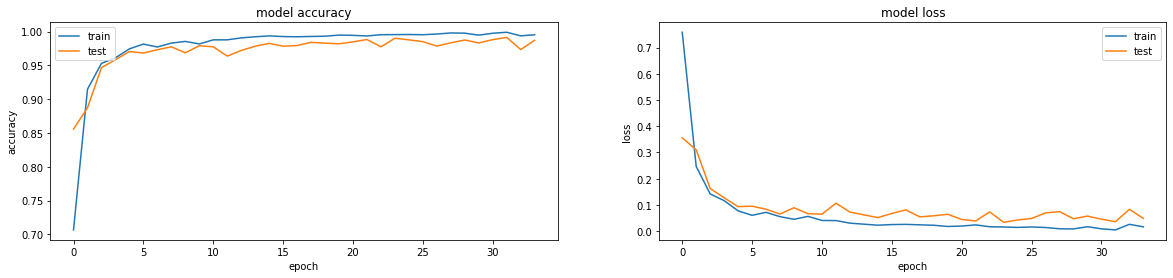

In [66]:
#------------------------------------------------------------------------------------------

import matplotlib.pyplot as plt

# This function is used to display the history the train/test accuracy/loss
# of the Keras training.
#
#   history - Pass in the history returned from the model.fit(...) method.
#
def display_training_loss_and_accuracy(history):
    
    plt.figure(figsize=(20,4))
    
    # summarize history for accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    
    # summarize history for loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()    

display_training_loss_and_accuracy(history)




In [67]:
labels = ["JUMPING", "JUMPING_JACKS", "BOXING", "WAVING_2HANDS", "WAVING_1HAND", "CLAPPING_HANDS"]

(22625, 32, 36)


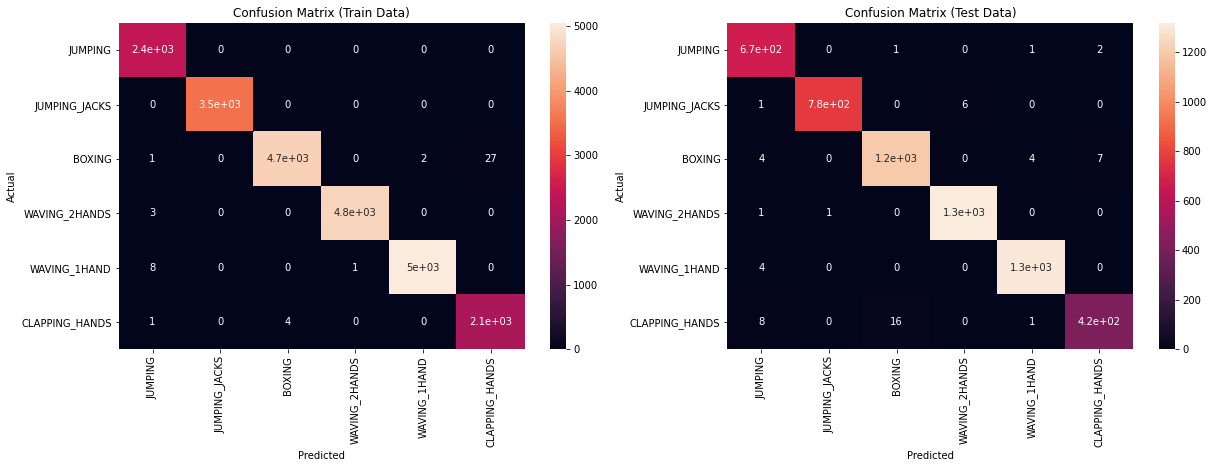

Train Data:
--------------------------------------------------------
                precision    recall  f1-score   support

       JUMPING       0.99      1.00      1.00      2400
 JUMPING_JACKS       1.00      1.00      1.00      3545
        BOXING       1.00      0.99      1.00      4724
 WAVING_2HANDS       1.00      1.00      1.00      4760
  WAVING_1HAND       1.00      1.00      1.00      5055
CLAPPING_HANDS       0.99      1.00      0.99      2141

      accuracy                           1.00     22625
     macro avg       1.00      1.00      1.00     22625
  weighted avg       1.00      1.00      1.00     22625


Test Data:
--------------------------------------------------------
                precision    recall  f1-score   support

       JUMPING       0.97      0.99      0.98       676
 JUMPING_JACKS       1.00      0.99      0.99       783
        BOXING       0.99      0.99      0.99      1216
 WAVING_2HANDS       1.00      1.00      1.00      1320
  WAVING_1HAND    

In [79]:
#------------------------------------------------------------------------------------------

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce
 
def display_classification_confusion_matrix(keras_model, x_train, y_train, x_test, y_test, labels):
    
    '''
    x_train = []
    x_test = []
    y_train = []
    y_test = []
    '''
 
    print(x_train.shape)
    train_preds = keras_model.predict(x_train)
    test_preds = keras_model.predict(x_test)
    train_preds = np.argmax(train_preds, axis=1)
    test_preds = np.argmax(test_preds, axis=1)
    #test_generator.on_epoch_end()

    plt.figure(figsize=(20,6))  

    labels = np.array(labels)
    # Print the first Confusion Matrix for the training data
    #
    cm = confusion_matrix(y_train, train_preds)

    cm_df = pd.DataFrame(cm, labels, labels)          
    plt.subplot(1, 2, 1)
    plt.title('Confusion Matrix (Train Data)')
    sns.heatmap(cm_df, annot=True)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')        
    
    # Print the second Confusion Matrix for the test data
    #    
    cm = confusion_matrix(y_test, test_preds)
    
    cm_df = pd.DataFrame(cm, labels, labels)          
    plt.subplot(1, 2, 2)
    plt.title('Confusion Matrix (Test Data)')
    sns.heatmap(cm_df, annot=True)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')        
    
    plt.show()

    # Finally display the classification reports
    #
    print ("Train Data:")
    print ("--------------------------------------------------------")
    print(classification_report(y_train, train_preds, target_names=labels))
    print ("")
    print ("Test Data:")
    print ("--------------------------------------------------------")
    print(classification_report(y_test, test_preds, target_names=labels))
    

# Exclude the O tags from the confusion matrix.
#
display_classification_confusion_matrix(model, X_train_normalized, y_train, X_test_normalized, y_test, labels)

## Section 9 - Save and Download Model

Run the following cell to save your model. 





In [80]:
model.save("model.savedmodel")

INFO:tensorflow:Assets written to: model.savedmodel/assets


INFO:tensorflow:Assets written to: model.savedmodel/assets


Run the following the zip the "model.savedmodel" folder into a single zip file.

Download that zip file from Colab once you are done! We will be using this for the next practical exercise.

In [81]:
!zip model.savedmodel.zip -r model.savedmodel

  adding: model.savedmodel/ (stored 0%)
  adding: model.savedmodel/saved_model.pb (deflated 89%)
  adding: model.savedmodel/variables/ (stored 0%)
  adding: model.savedmodel/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: model.savedmodel/variables/variables.index (deflated 59%)
  adding: model.savedmodel/assets/ (stored 0%)
  adding: model.savedmodel/keras_metadata.pb (deflated 86%)


In [82]:
model = keras.models.load_model('model.savedmodel')

In [84]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 128)               84480     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 774       
Total params: 85,254
Trainable params: 85,254
Non-trainable params: 0
_________________________________________________________________


In [85]:
sample_index = 2000
sample = X_test[sample_index]
label = y_test[sample_index]


In [86]:
sample = np.expand_dims(sample, axis=0)

In [87]:
pred = model(sample)

In [88]:
print('actual = {}'.format(labels[np.argmax(label)]))
print('predicted = {}'.format(labels[np.argmax(pred)]))

actual = JUMPING
predicted = JUMPING
